In [45]:
import os
import json
from collections import defaultdict
import pandas as pd

import torch
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.special import softmax
from scipy.stats import entropy

from fairseq import tasks, options

In [2]:
MODEL_PATH = 'mtransformer/de-en/'
CHECKPOINT_PATHS = [
    'model1.pt',
    'model2.pt',
    'model3.pt',
    'model4.pt',
    'model5.pt',
]
CHECKPOINT_PATHS = [os.path.join(MODEL_PATH, path) for path in CHECKPOINT_PATHS]

MODEL_PATH = ':'.join(CHECKPOINT_PATHS)
BINARY_DATA_PATH = 'data-bin/iwslt14.tokenized.de-en/'
# BPECODES_PATH = 'wmt19.en-ru.ensemble/codes'
BPECODES_PATH = 'data/iwslt14.tokenized.de-en/code' # иначе лажа какая-то получается
BEAM = '5'
LENPEN = '0.6'
DIVERSE_BEAM_STRENGTH = '0'
SHARED_BPE = True
SRS = "en"
TGT = "ru"

parser = options.get_generation_parser(interactive=True)

args = options.parse_args_and_arch(parser, input_args=[
    BINARY_DATA_PATH,
    '--path', MODEL_PATH,
    '--diverse-beam-strength', DIVERSE_BEAM_STRENGTH,
    '--lenpen', 0,
    '--remove-bpe',
    '--beam', BEAM
])

use_cuda = False
task = tasks.setup_task(args)
tgt_dict = task.target_dictionary

| [de] dictionary: 8848 types
| [en] dictionary: 6632 types


In [3]:
MODELS_NUM = 5

---

In [4]:
def safety_log(values):
    values = values.copy()
    mask = values == 0
    values[mask] = 1e-32
    
    return np.log2(values)

In [5]:
def plot_softmax(tokens, probs, title, label, ax, f_ylim=True): 
    ax.plot(tokens, probs, alpha=.5, label=label)
    ax.scatter(tokens, probs, alpha=.5)
    if f_ylim:
        ax.set_ylim(0, 1)
    ax.set_xlabel('token')
    ax.set_ylabel('token prob $p(y)$')
    ax.set_title(title + ' softmax')
    ax.grid()
    ax.legend()

In [6]:
def plot_stat(
    stat_list,
    name_list,
    colors,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    normalized=True,
    map_func=lambda x: x,
    bins=70,
):
    density = stacked = normalized

    for name, stat, color in zip(name_list, stat_list, colors):
        plt.hist(
            map_func(stat),
            density=density, stacked=stacked,
            color=color, alpha=.4,
            bins=bins,
            label='{} ({})'.format(name, len(stat))
        )

    plt.title('Beam Size: {}. {}'.format(beam, title))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim is not None:
        plt.ylim(ylim)
    if xlim is not None:
        plt.xlim(xlim)
    plt.grid()
    plt.legend()

In [72]:
def plot_stat_ax(
    stat_list,
    name_list,
    colors,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    ax,
    normalized=True,
    map_func=lambda x: x,
    bins=70,
):
    density = stacked = normalized

    for name, stat, color in zip(name_list, stat_list, colors):
        if color is not None:
            ax.hist(
                map_func(stat),
                density=density, stacked=stacked,
                color=color, alpha=.4,
                bins=bins,
                label='{} ({})'.format(name, len(stat))
            )
        else:
            ax.hist(
                map_func(stat),
                density=density, stacked=stacked,
                alpha=.4,
                bins=bins,
                label='{} ({})'.format(name, len(stat))
            )

    ax.set_title('Beam Size: {}. {}'.format(beam, title))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.grid()
    ax.legend()

In [147]:
def plot_scatter_ax(
    stat_list,
    stat2_list,
    name_list,
    colors,
    title,
    xlabel,
    ylabel,
    xlim,
    ylim,
    ax,
    normalized=True,
    map_func=lambda x: x,
    map2_func=lambda x: x,
    bins=70,
):
    density = stacked = normalized

    for name, stat, stat2, color in zip(name_list, stat_list, stat2_list, colors):
        if color is not None:
            ax.scatter(
                map_func(stat),
                map2_func(stat2),
                color=color, alpha=.4,
                label='{} ({})'.format(name, len(stat))
            )
        else:
            ax.scatter(
                map_func(stat),
                map2_func(stat2),
                alpha=.4,
                label='{} ({})'.format(name, len(stat))
            )

    ax.set_title('Beam Size: {}. {}'.format(beam, title))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    ax.grid()
    ax.legend()

---

In [22]:
stats_dir = 'mtransformer/de-en/stats_softmaxes_transform/'

positive_filename = 'positive_stats.json'
negative_filename = 'negative_stats.json'
negative_true_filename = 'negative_true_stats.json'
wrong_filename = 'wrong_suff_stats.json'
random_filename = 'random_stats.json'

beam2stats_pos = defaultdict(list)
beam2stats_neg = defaultdict(list)
beam2stats_neg_true = defaultdict(list)
beam2stats_wrong = defaultdict(list)
beam2stats_random = defaultdict(list)

for beam_dir in os.listdir(stats_dir):
    beam = int(beam_dir.split('_')[-1])
    if beam != 1:
        continue
    
    path = os.path.join(stats_dir, beam_dir)
    with open(os.path.join(path, positive_filename)) as input_stream:
        beam2stats_pos[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_filename)) as input_stream:
        beam2stats_neg[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_true_filename)) as input_stream:
        beam2stats_neg_true[beam] = json.load(input_stream)
        
    with open(os.path.join(path, wrong_filename)) as input_stream:
        beam2stats_wrong[beam] = json.load(input_stream)
        
    with open(os.path.join(path, random_filename)) as input_stream:
        beam2stats_random[beam] = json.load(input_stream)

#### Log probs

In [23]:
beams = list(beam2stats_pos.keys())

---

In [37]:
import numpy as np

In [24]:
beam2stats_neg[1].keys()

dict_keys(['inens_probs_var', 'softmax_probs', 'prob', 'tokens'])

In [25]:
inens_vars = np.array(beam2stats_neg[1]['inens_probs_var'])
softmaxes = np.array(beam2stats_neg[1]['softmax_probs'])

negative = np.array(beam2stats_neg[1]['tokens'])
positive = np.array(beam2stats_neg_true[1]['tokens'])
random = np.array(beam2stats_random[1]['tokens'])

rows = np.arange(softmaxes.shape[0])

In [90]:
TOKENS_COLLECTION_ZIPPED = [
    ('first error', 'blue', negative),
    ('correct token', 'red', positive),
    ('random token', 'yellow', random),
]

TOKENS_NAMES, TOKENS_COLORS, TOKENS_COLLECTION = zip(*TOKENS_COLLECTION_ZIPPED)

In [91]:
TOP_LIST = np.array([3, 5, 20])
MAX_TOP = int(max(TOP_LIST))

In [92]:
values, indices = torch.topk(torch.from_numpy(softmaxes), MAX_TOP, dim=-1)
values, indices = values.numpy(), indices.numpy()

In [93]:
TOP_TOKENS_COLLECTION

[('top-3 token', None, array([2016, 1981,   18, ...,  112, 2001,  112])),
 ('top-5 token', None, array([  30,  329,  139, ...,  505, 4121,  505])),
 ('top-20 token', None, array([ 36, 396, 262, ..., 548, 187, 548]))]

In [94]:
TOP_TOKENS_COLLECTION_ZIPPED = [
    ('top-{} token'.format(top), None, indices[:, top - 1])
    
    for top in TOP_LIST
]

TOP_TOKENS_COLLECTION_ZIPPED = TOKENS_COLLECTION_ZIPPED + TOP_TOKENS_COLLECTION_ZIPPED

TOP_TOKENS_NAMES, TOP_TOKENS_COLORS, TOP_TOKENS_COLLECTION = zip(*TOP_TOKENS_COLLECTION_ZIPPED)

#### default

In [95]:
softmax_transformer = lambda ens_logprobs, inens_var: np.exp(ens_logprobs)
get_stats = lambda softmax, tokens: softmax[rows, tokens]

softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

probs_collection = []
for tokens in TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )

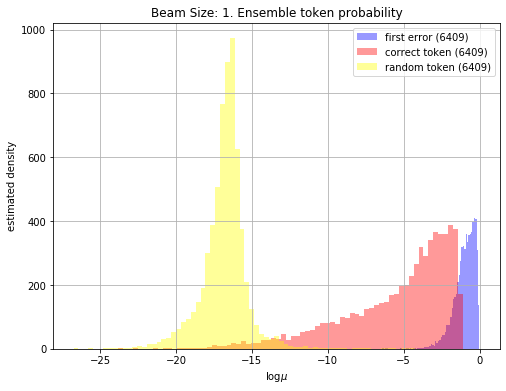

In [96]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOKENS_NAMES,
    TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=np.log2
)

In [108]:
softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs, axis=-1)
get_stats = lambda softmax, tokens: softmax[rows, tokens]

softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

probs_collection = []
for tokens in TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )

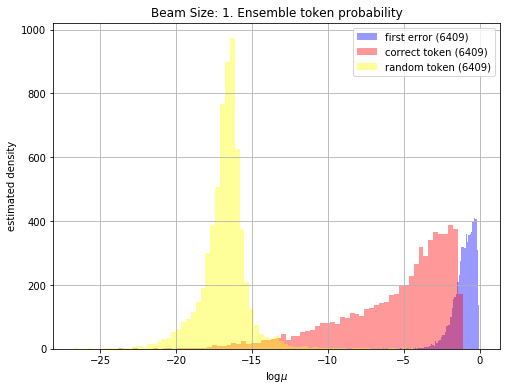

In [109]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOKENS_NAMES,
    TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=np.log2
)

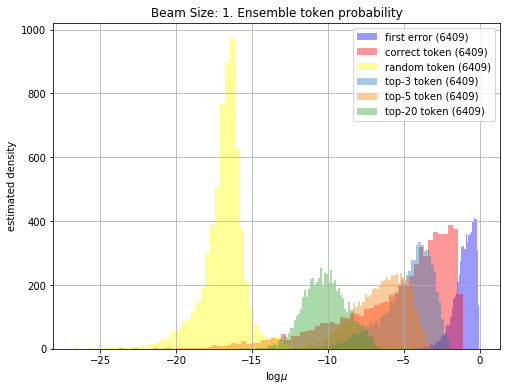

In [97]:
probs_collection = []
for tokens in TOP_TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
    
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOP_TOKENS_NAMES,
    TOP_TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=np.log2
)

---

#### $\log p(y) - \log\sigma^2$

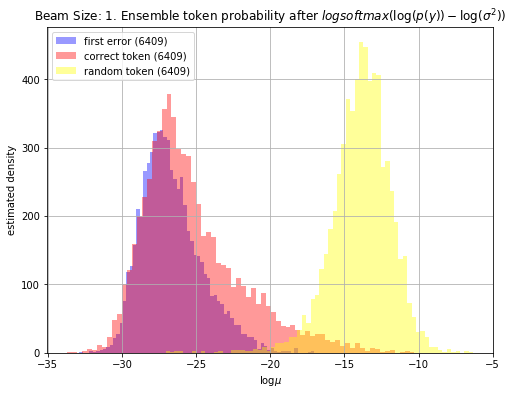

In [110]:
softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - np.log(inens_var), axis=-1)
get_stats = lambda softmax, tokens: softmax[rows, tokens]

softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

probs_collection = []
for tokens in TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
# ---------------------------------------------------

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\sigma^2))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOKENS_NAMES,
    TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log
)

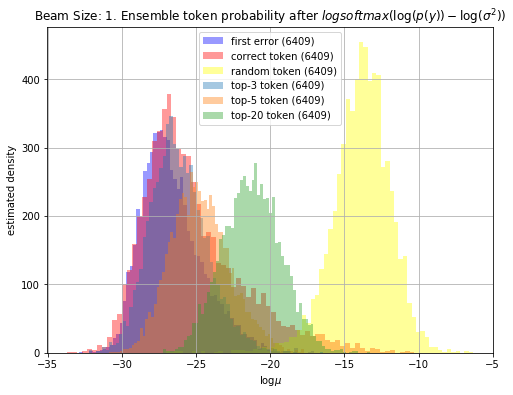

In [111]:
probs_collection = []
for tokens in TOP_TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
# ---------------------------------------------------

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\sigma^2))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOP_TOKENS_NAMES,
    TOP_TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log
)

In [137]:
inens_vars.shape

(6409, 6632)

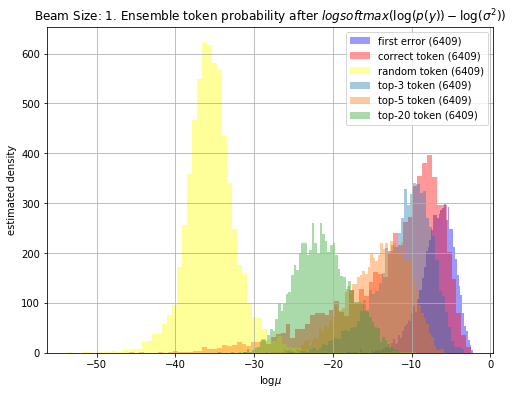

In [139]:
probs_collection = []
for tokens in TOP_TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(inens_vars, tokens)
    )
# ---------------------------------------------------
    

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\sigma^2))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOP_TOKENS_NAMES,
    TOP_TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log
)

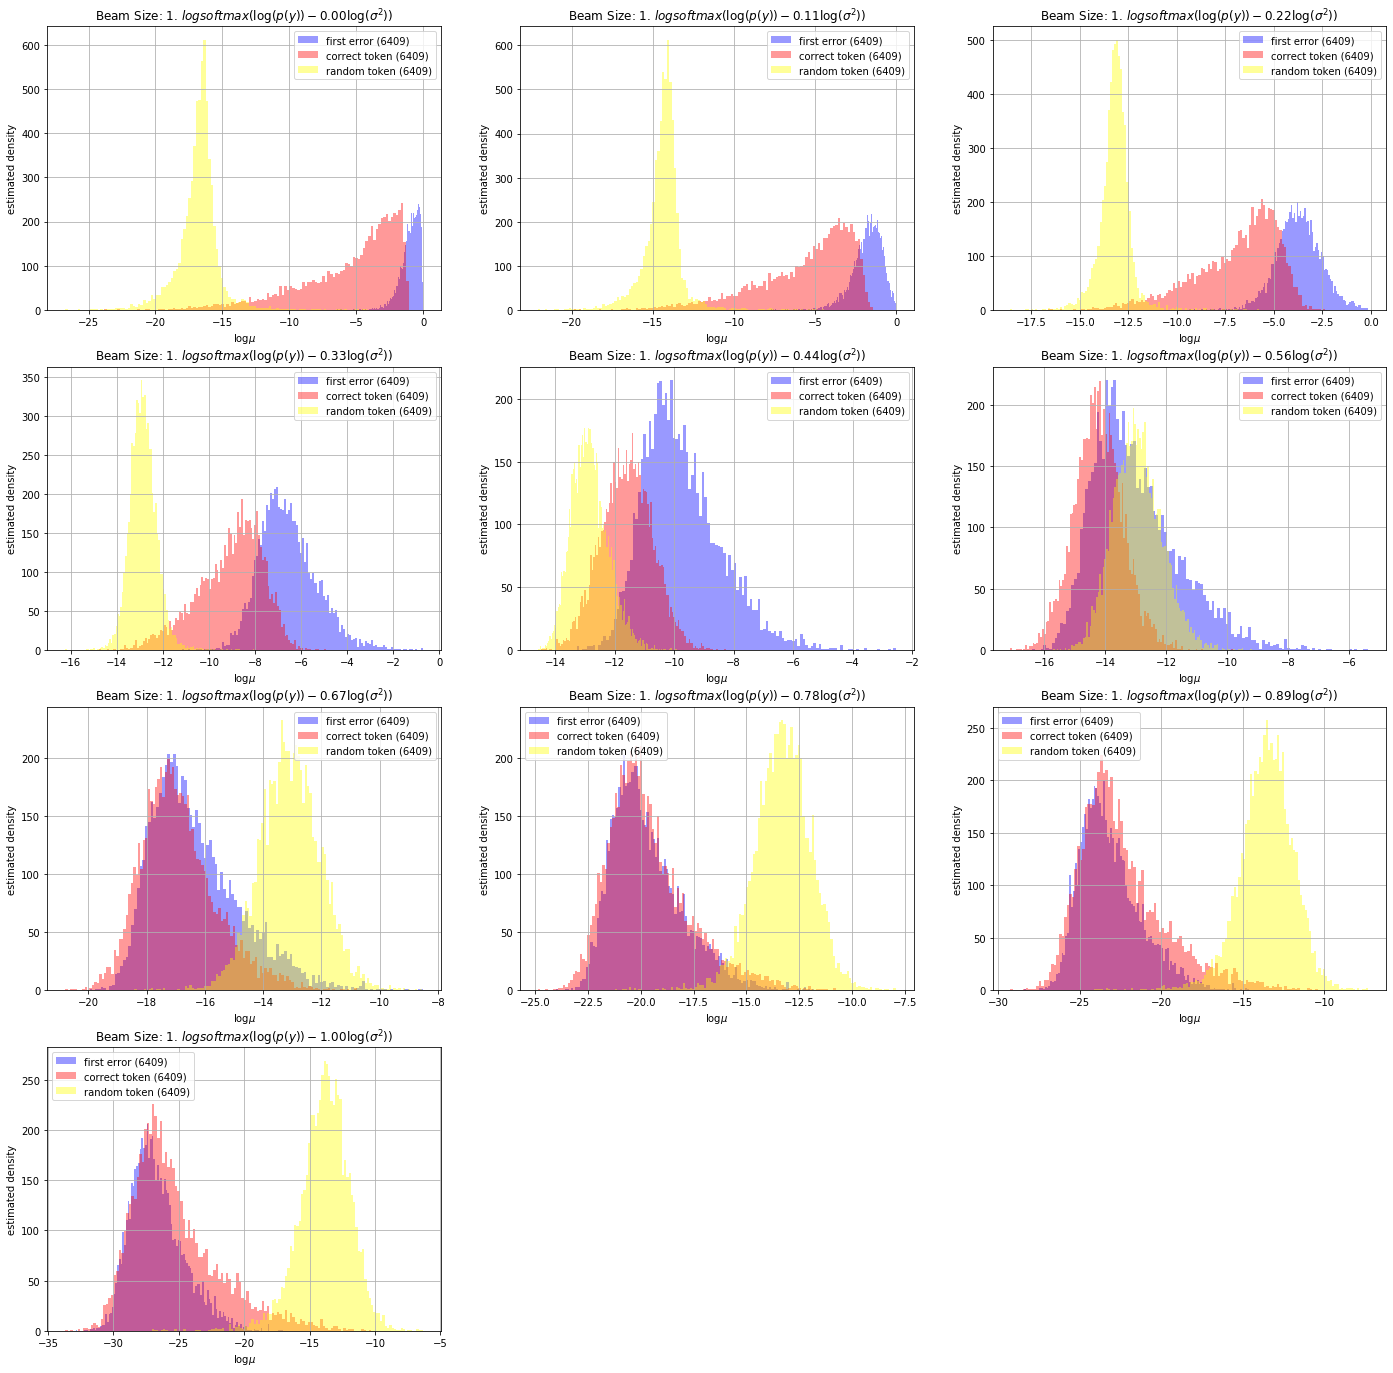

In [141]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

alphas = np.linspace(0, 1, 10)

m = 3
n = alphas.shape[0] // m + (1 if (alphas.shape[0] % m) != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - alpha * np.log(inens_var), axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

    probs_collection = []
    for tokens in TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(\sigma^2))$'.format(alpha)

    plot_stat_ax(
        probs_collection,
        TOKENS_NAMES,
        TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        bins=120,
    )

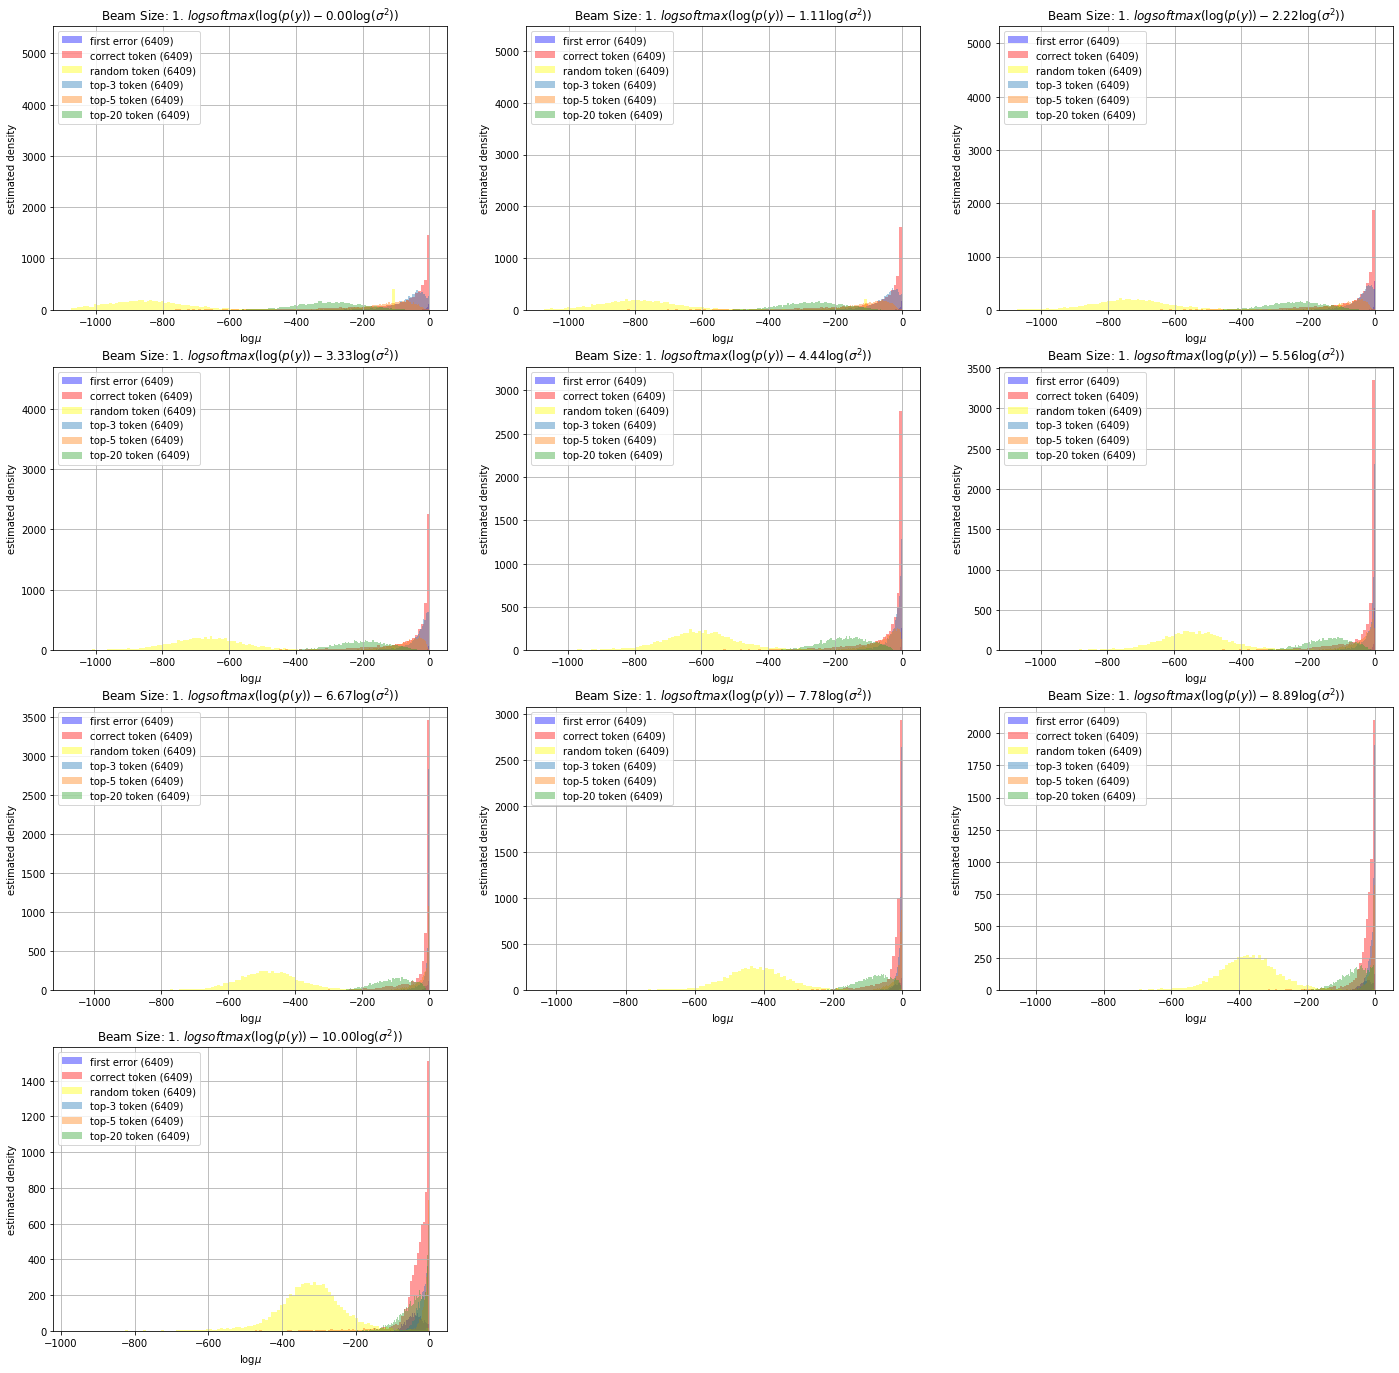

In [158]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

alphas = np.linspace(0, 10, 10)

m = 3
n = alphas.shape[0] // m + (1 if (alphas.shape[0] % m) != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - (np.log(inens_var) + alpha) ** 2, axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

    probs_collection = []
    for tokens in TOP_TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(\sigma^2))$'.format(alpha)

    plot_stat_ax(
        probs_collection,
        TOP_TOKENS_NAMES,
        TOP_TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        bins=120,
    )

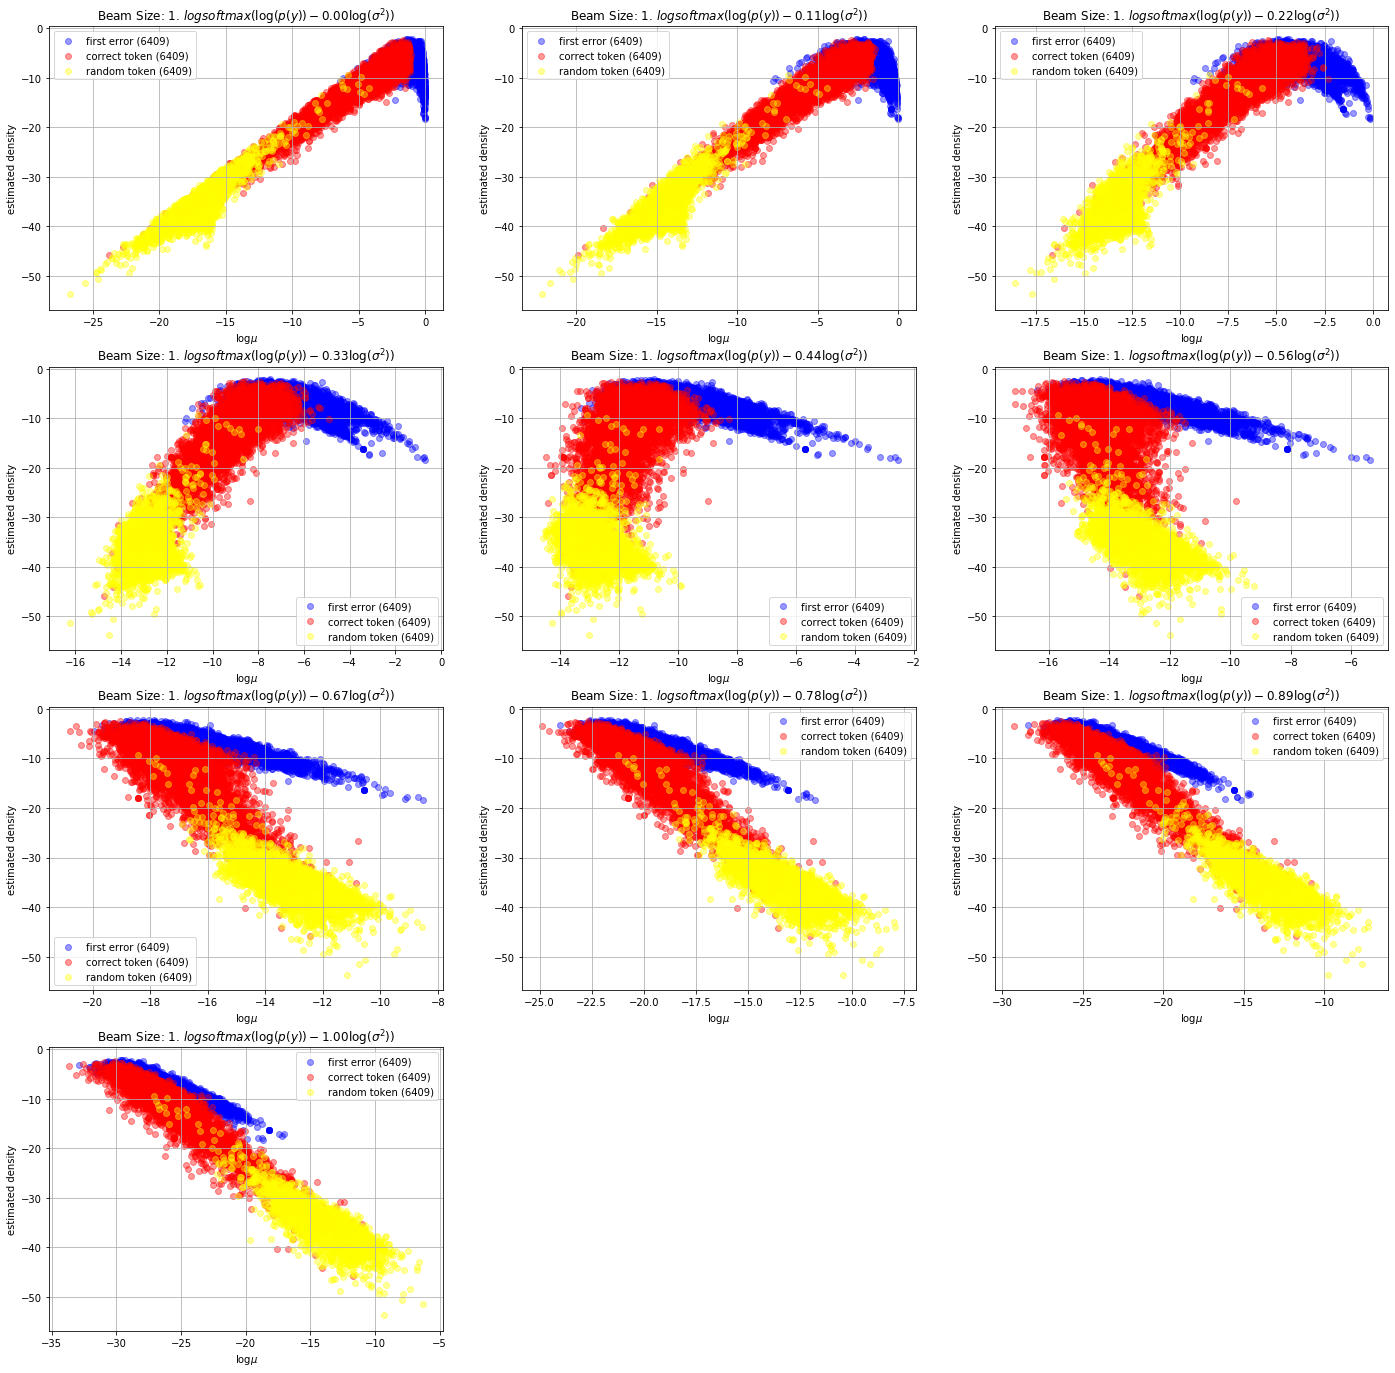

In [150]:
plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - alpha * (np.log(inens_var)), axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

    probs_collection = []
    for tokens in TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(\sigma^2))$'.format(alpha)

    plot_scatter_ax(
        probs_collection,
        probs2_collection,
        TOKENS_NAMES,
        TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        map2_func=np.log2,
        bins=120,
    )

In [159]:
    probs2_collection = []
    for tokens in TOP_TOKENS_COLLECTION:
        probs2_collection.append(
            get_stats(inens_vars, tokens)
        )

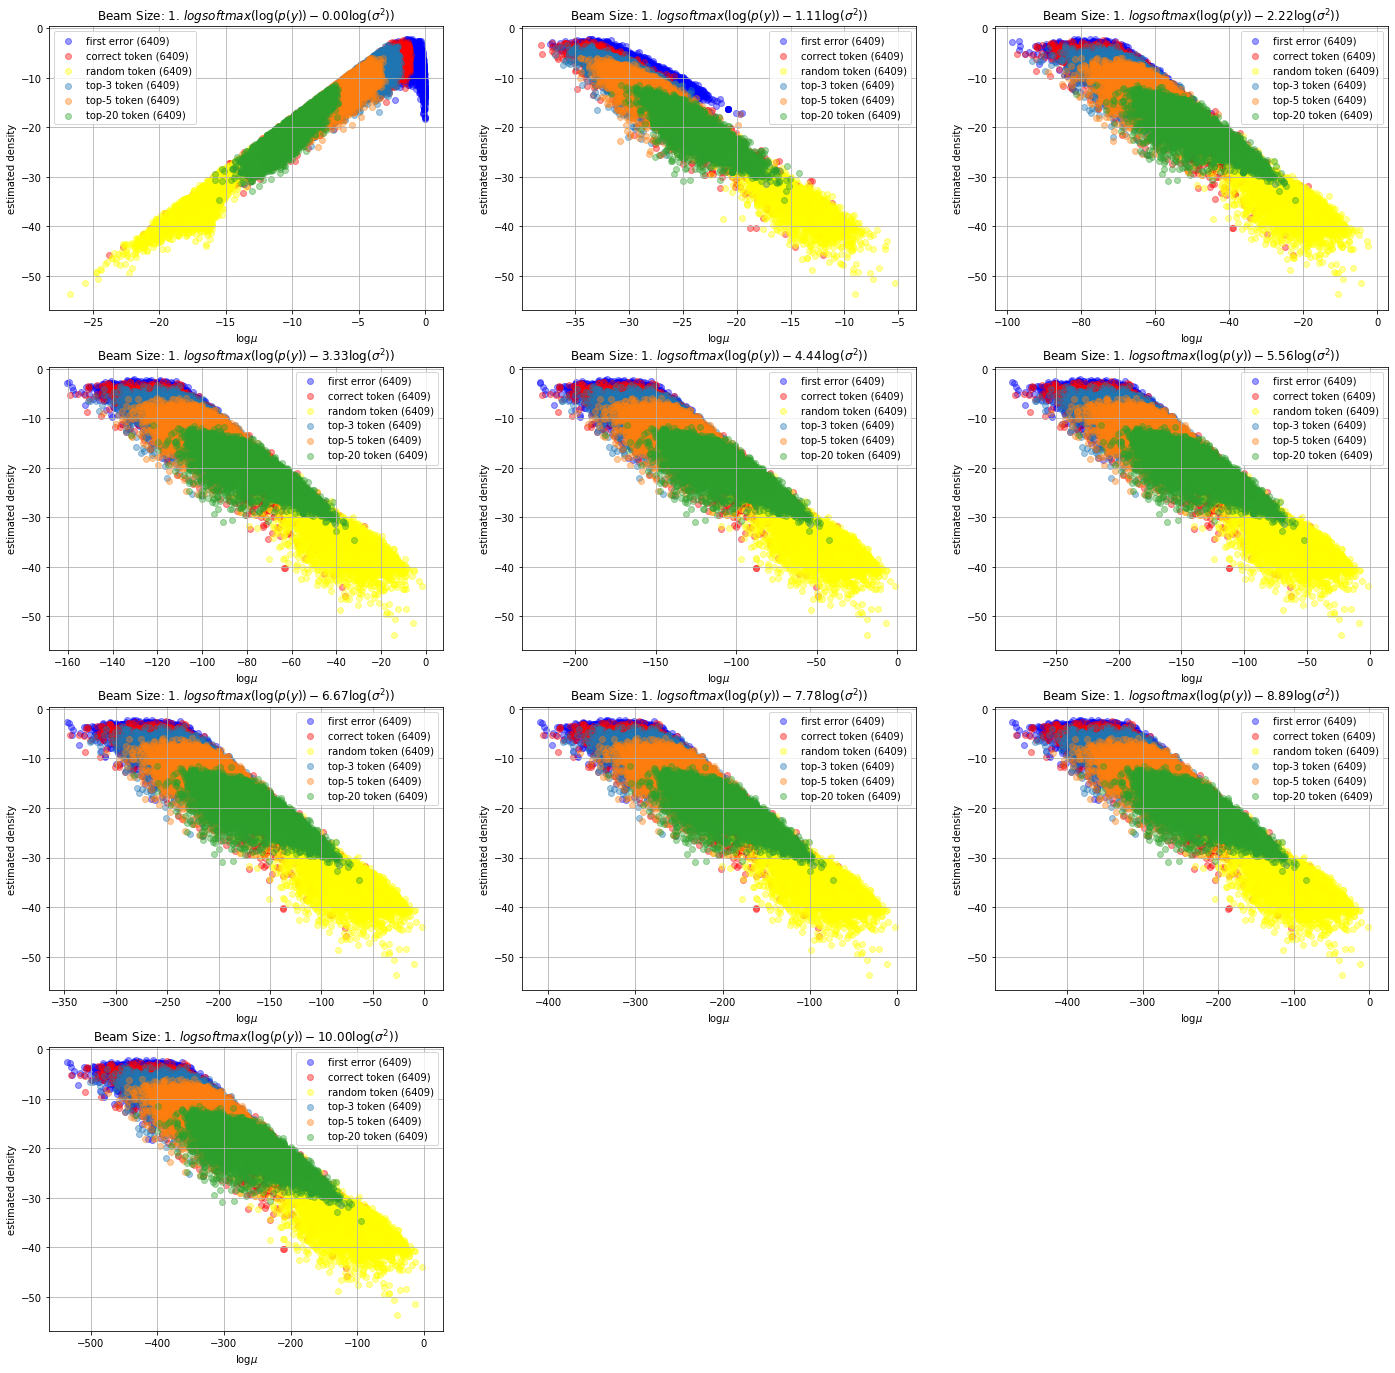

In [160]:
plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - alpha * (np.log(inens_var)), axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

    probs_collection = []
    for tokens in TOP_TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(\sigma^2))$'.format(alpha)

    plot_scatter_ax(
        probs_collection,
        probs2_collection,
        TOP_TOKENS_NAMES,
        TOP_TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        map2_func=np.log2,
        bins=120,
    )

In [142]:
    probs2_collection = []
    for tokens in TOKENS_COLLECTION:
        probs2_collection.append(
            get_stats(inens_vars, tokens)
        )

In [154]:
alphas = np.linspace(0, 10, 10)

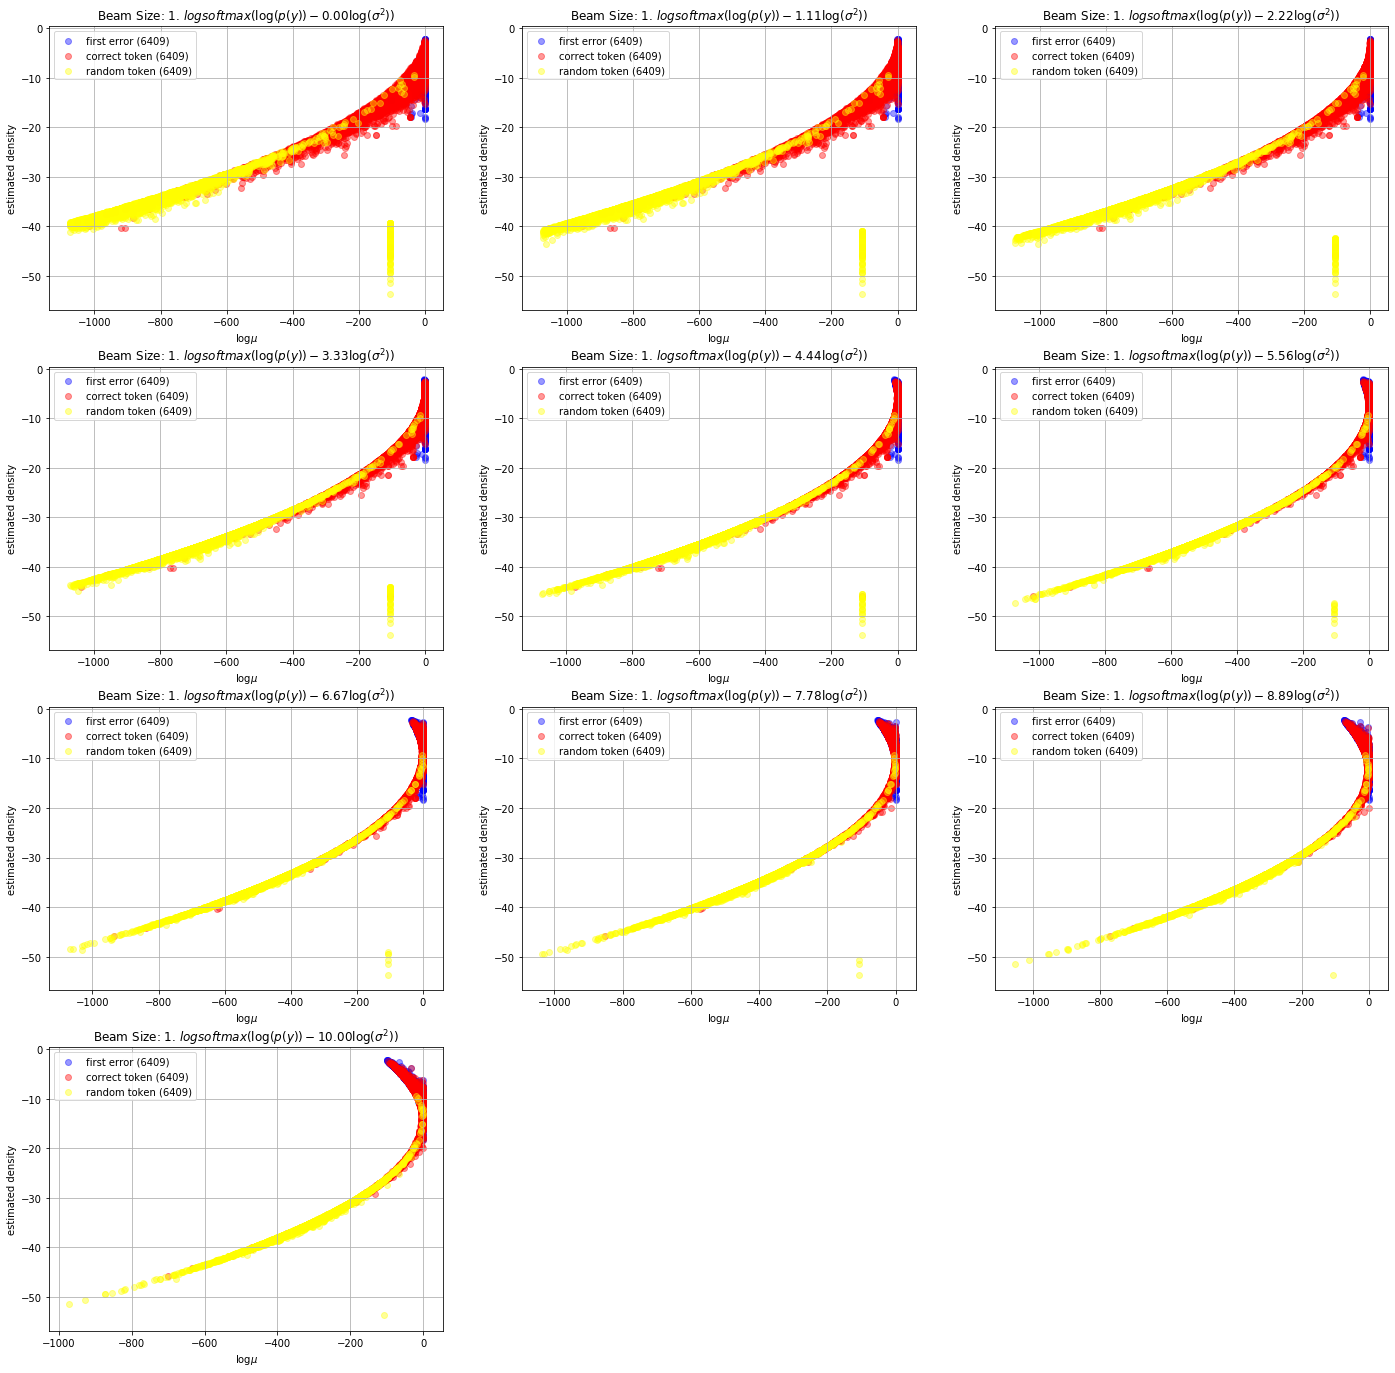

In [155]:
plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - (np.log(inens_var) + alpha) ** 2, axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

    probs_collection = []
    for tokens in TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(\sigma^2))$'.format(alpha)

    plot_scatter_ax(
        probs_collection,
        probs2_collection,
        TOKENS_NAMES,
        TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        map2_func=np.log2,
        bins=120,
    )

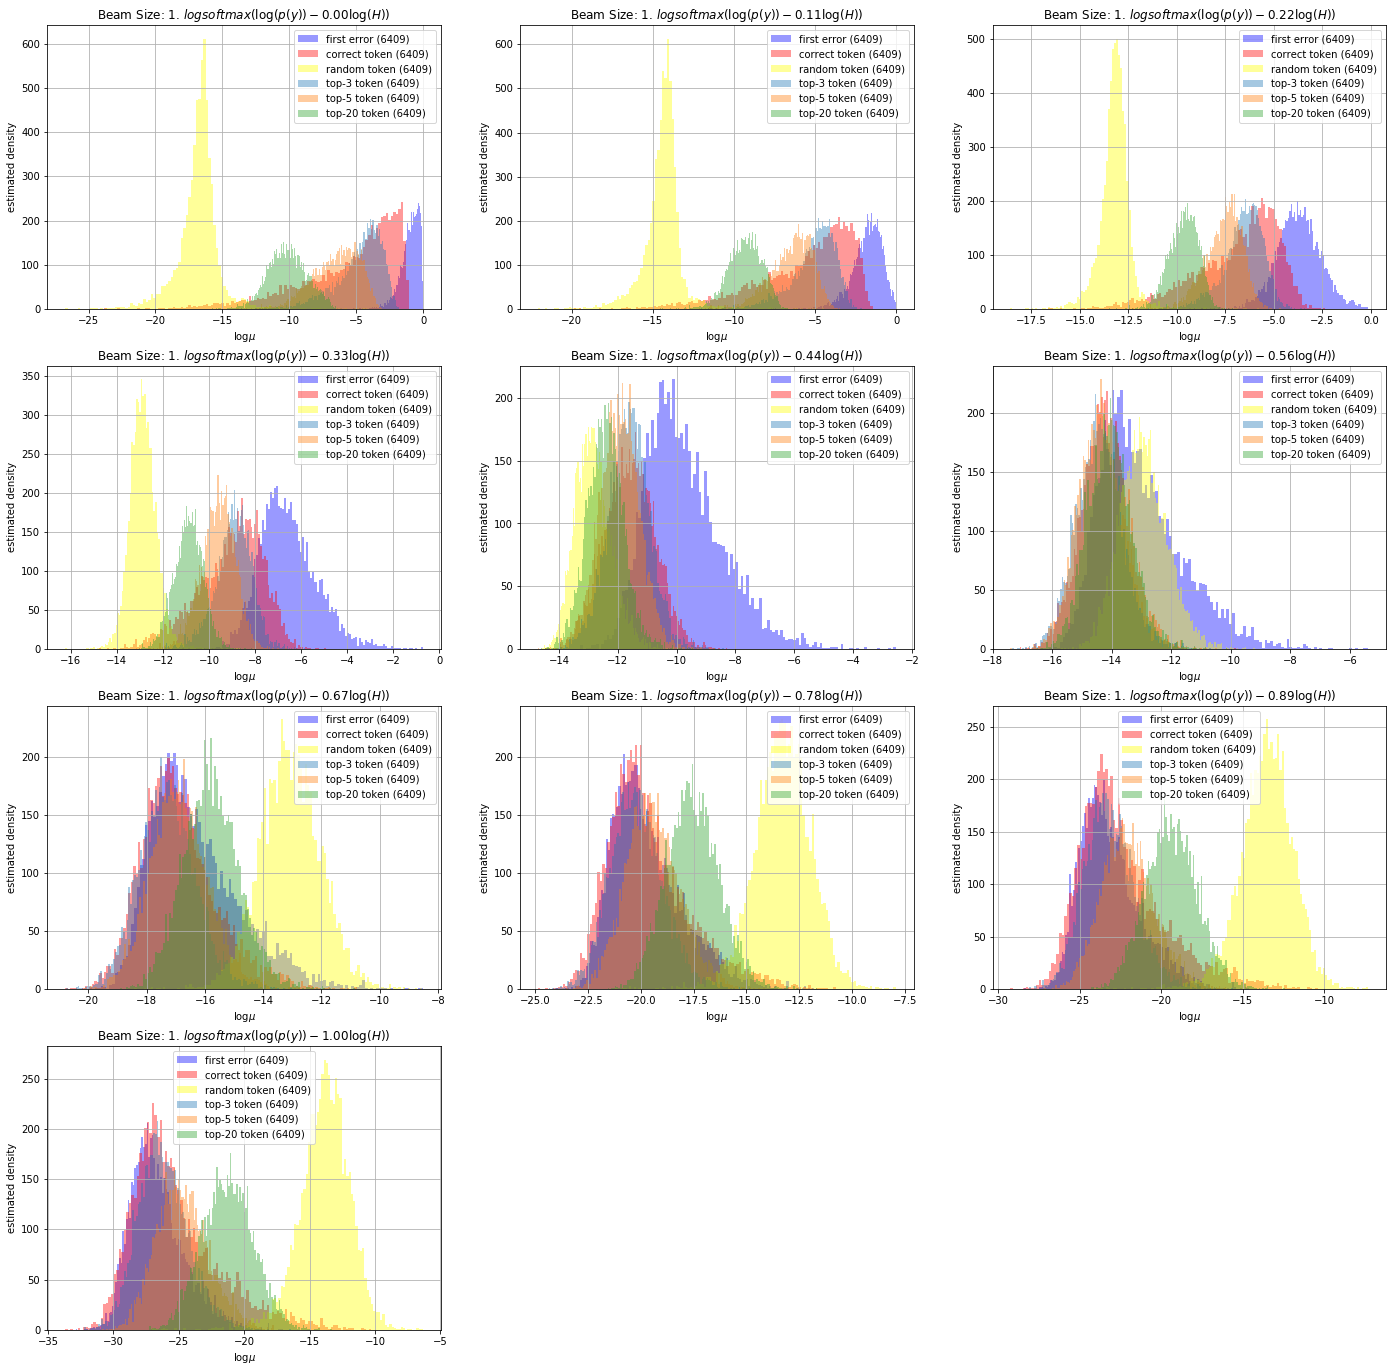

In [135]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

alphas = np.linspace(0, 1, 10)

m = 3
n = alphas.shape[0] // m + (1 if (alphas.shape[0] % m) != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - alpha * np.log(inens_var), axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

    probs_collection = []
    for tokens in TOP_TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(\sigma^2))$'.format(alpha)

    plot_stat_ax(
        probs_collection,
        TOP_TOKENS_NAMES,
        TOP_TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        bins=120,
    )

#### $\log p(y) - \log\sigma$

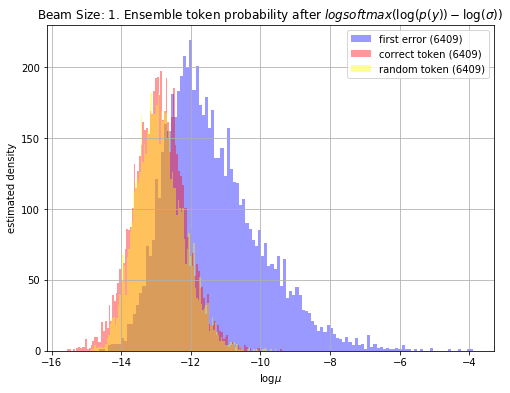

In [114]:
softmax_transformer = lambda ens_logprobs, inens_var: softmax(ens_logprobs - np.log(np.sqrt(inens_var)), axis=-1)
get_stats = lambda softmax, tokens: softmax[rows, tokens]

softmaxes_transformed = softmax_transformer(softmaxes, inens_vars)

probs_collection = []
for tokens in TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
# ---------------------------------------------------

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\sigma))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOKENS_NAMES,
    TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log,
    bins=120,
)

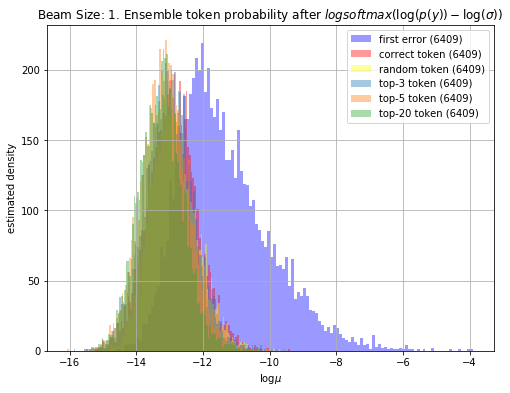

In [115]:
probs_collection = []
for tokens in TOP_TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
# ---------------------------------------------------

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\sigma))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOP_TOKENS_NAMES,
    TOP_TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log,
    bins=120,
)

---

#### $\log p(y) - log(\mathcal{H})$

In [116]:
stats_dir = 'mtransformer/de-en/correct_stats_with_random/'

positive_filename = 'positive_stats.json'
negative_filename = 'negative_stats.json'
negative_true_filename = 'negative_true_stats.json'
wrong_filename = 'wrong_suff_stats.json'
random_filename = 'random_stats.json'

beam2stats_pos = defaultdict(list)
beam2stats_neg = defaultdict(list)
beam2stats_neg_true = defaultdict(list)
beam2stats_wrong = defaultdict(list)
beam2stats_random = defaultdict(list)

for beam_dir in os.listdir(stats_dir):
    beam = int(beam_dir.split('_')[-1])
    if beam != 1:
        continue
    
    path = os.path.join(stats_dir, beam_dir)
    with open(os.path.join(path, positive_filename)) as input_stream:
        beam2stats_pos[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_filename)) as input_stream:
        beam2stats_neg[beam] = json.load(input_stream)
        
    with open(os.path.join(path, negative_true_filename)) as input_stream:
        beam2stats_neg_true[beam] = json.load(input_stream)
        
    with open(os.path.join(path, wrong_filename)) as input_stream:
        beam2stats_wrong[beam] = json.load(input_stream)
        
    with open(os.path.join(path, random_filename)) as input_stream:
        beam2stats_random[beam] = json.load(input_stream)

In [117]:
beam2stats_neg[1].keys()

dict_keys(['inens_probs_var', 'inens_probs_mean', 'softmax_probs_var_models', 'softmax_probs_entropy_models', 'softmax_probs_var_ens', 'softmax_probs_entropy_ens', 'prob', 'tokens'])

In [118]:
ens_entropy = np.array(beam2stats_neg[1]['softmax_probs_entropy_ens'])

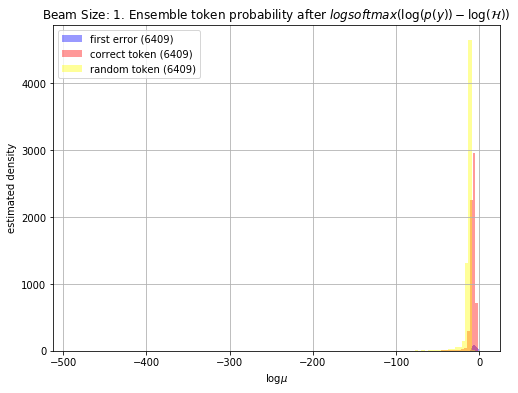

In [127]:
softmax_transformer = lambda ens_logprobs, entropy: softmax(ens_logprobs / entropy[np.newaxis].T, axis=-1)
get_stats = lambda softmax, tokens: softmax[rows, tokens]

softmaxes_transformed = softmax_transformer(softmaxes, ens_entropy)

probs_collection = []
for tokens in TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
# ---------------------------------------------------

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\mathcal{H}))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOKENS_NAMES,
    TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log,
    bins=120,
)

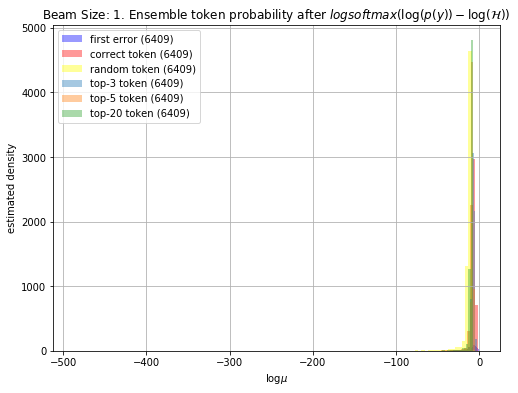

In [128]:
probs_collection = []
for tokens in TOP_TOKENS_COLLECTION:
    probs_collection.append(
        get_stats(softmaxes_transformed, tokens)
    )
# ---------------------------------------------------

YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

TITLE = r'Ensemble token probability after $logsoftmax(\log(p(y)) - \log(\mathcal{H}))$'
XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

plt.figure(figsize=(8, 6))
plot_stat(
    probs_collection,
    TOP_TOKENS_NAMES,
    TOP_TOKENS_COLORS,
    TITLE,
    XLABEL,
    YLABEL,
    XLIM,
    YLIM,
    NORMALIZED,
    map_func=safety_log,
    bins=120,
)

####  $logsoftmax(\log(p(y)) - \alpha * \log(\mathcal{H})$

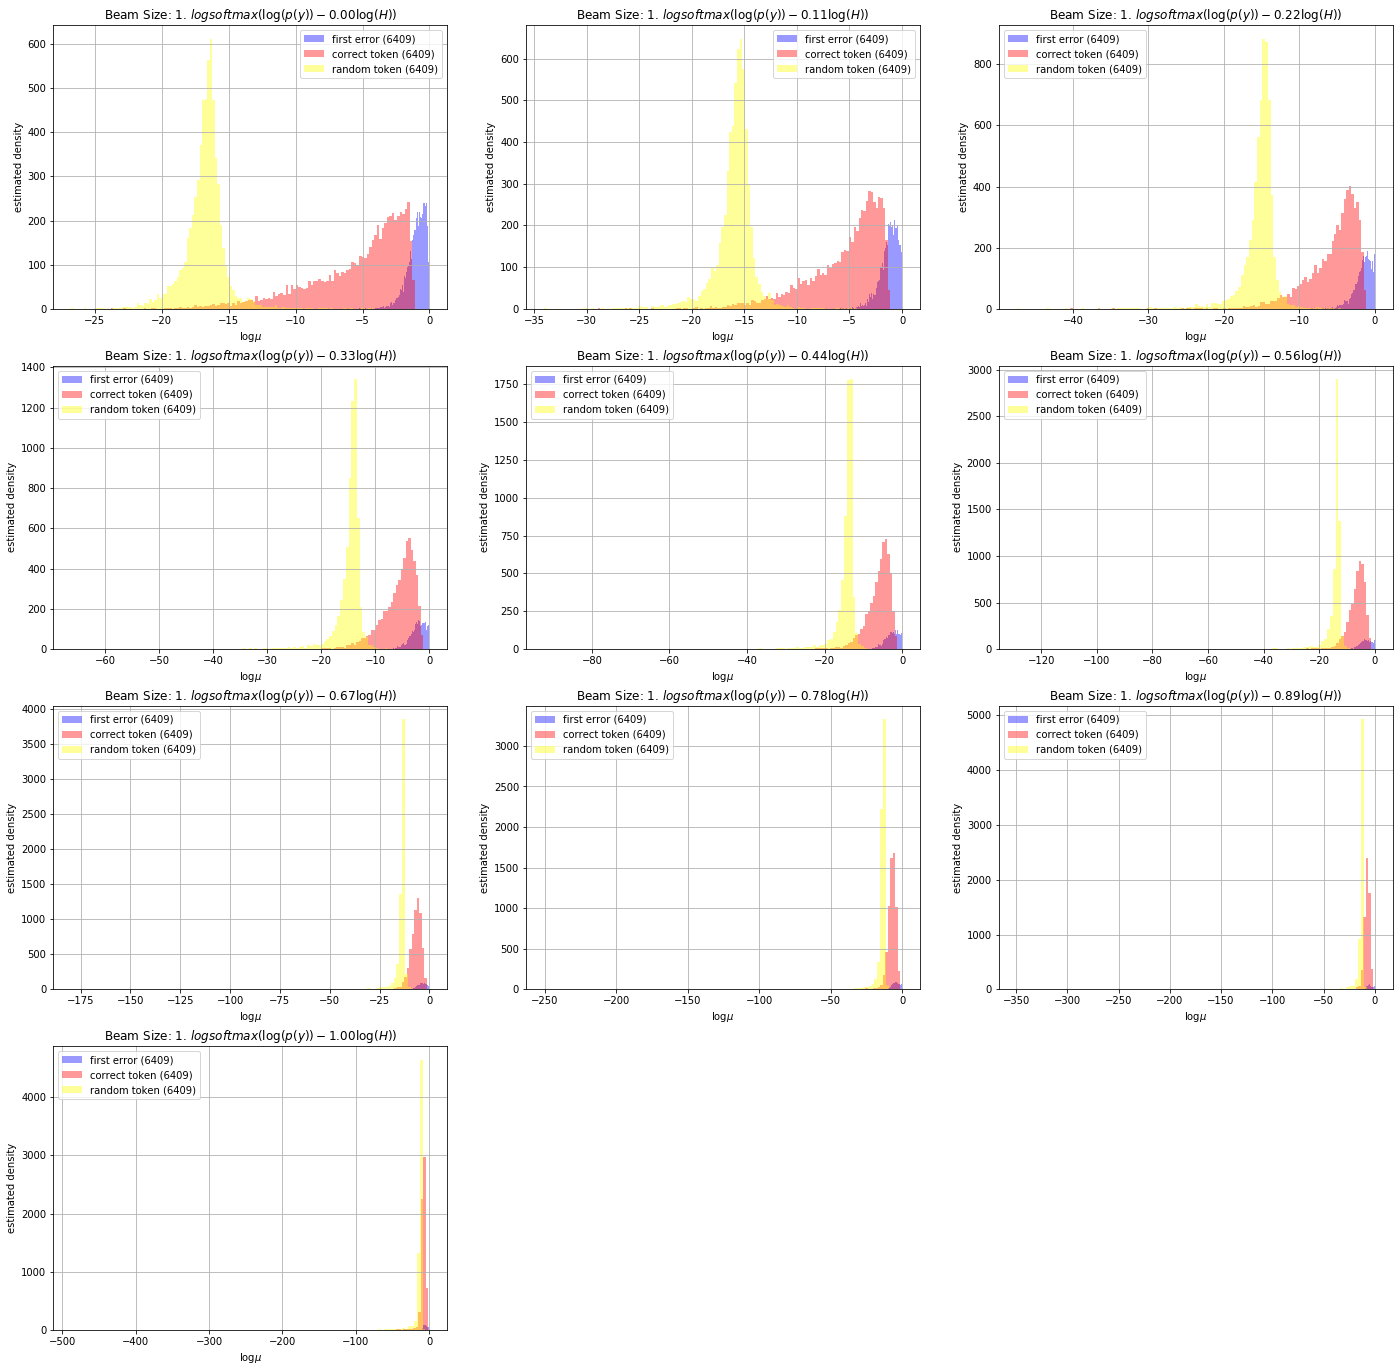

In [131]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

alphas = np.linspace(0, 1, 10)

m = 3
n = alphas.shape[0] // m + (1 if (alphas.shape[0] % m) != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, entropy: softmax(ens_logprobs / (entropy[np.newaxis].T ** alpha), axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, ens_entropy)

    probs_collection = []
    for tokens in TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(H))$'.format(alpha)

    plot_stat_ax(
        probs_collection,
        TOKENS_NAMES,
        TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        bins=120,
    )

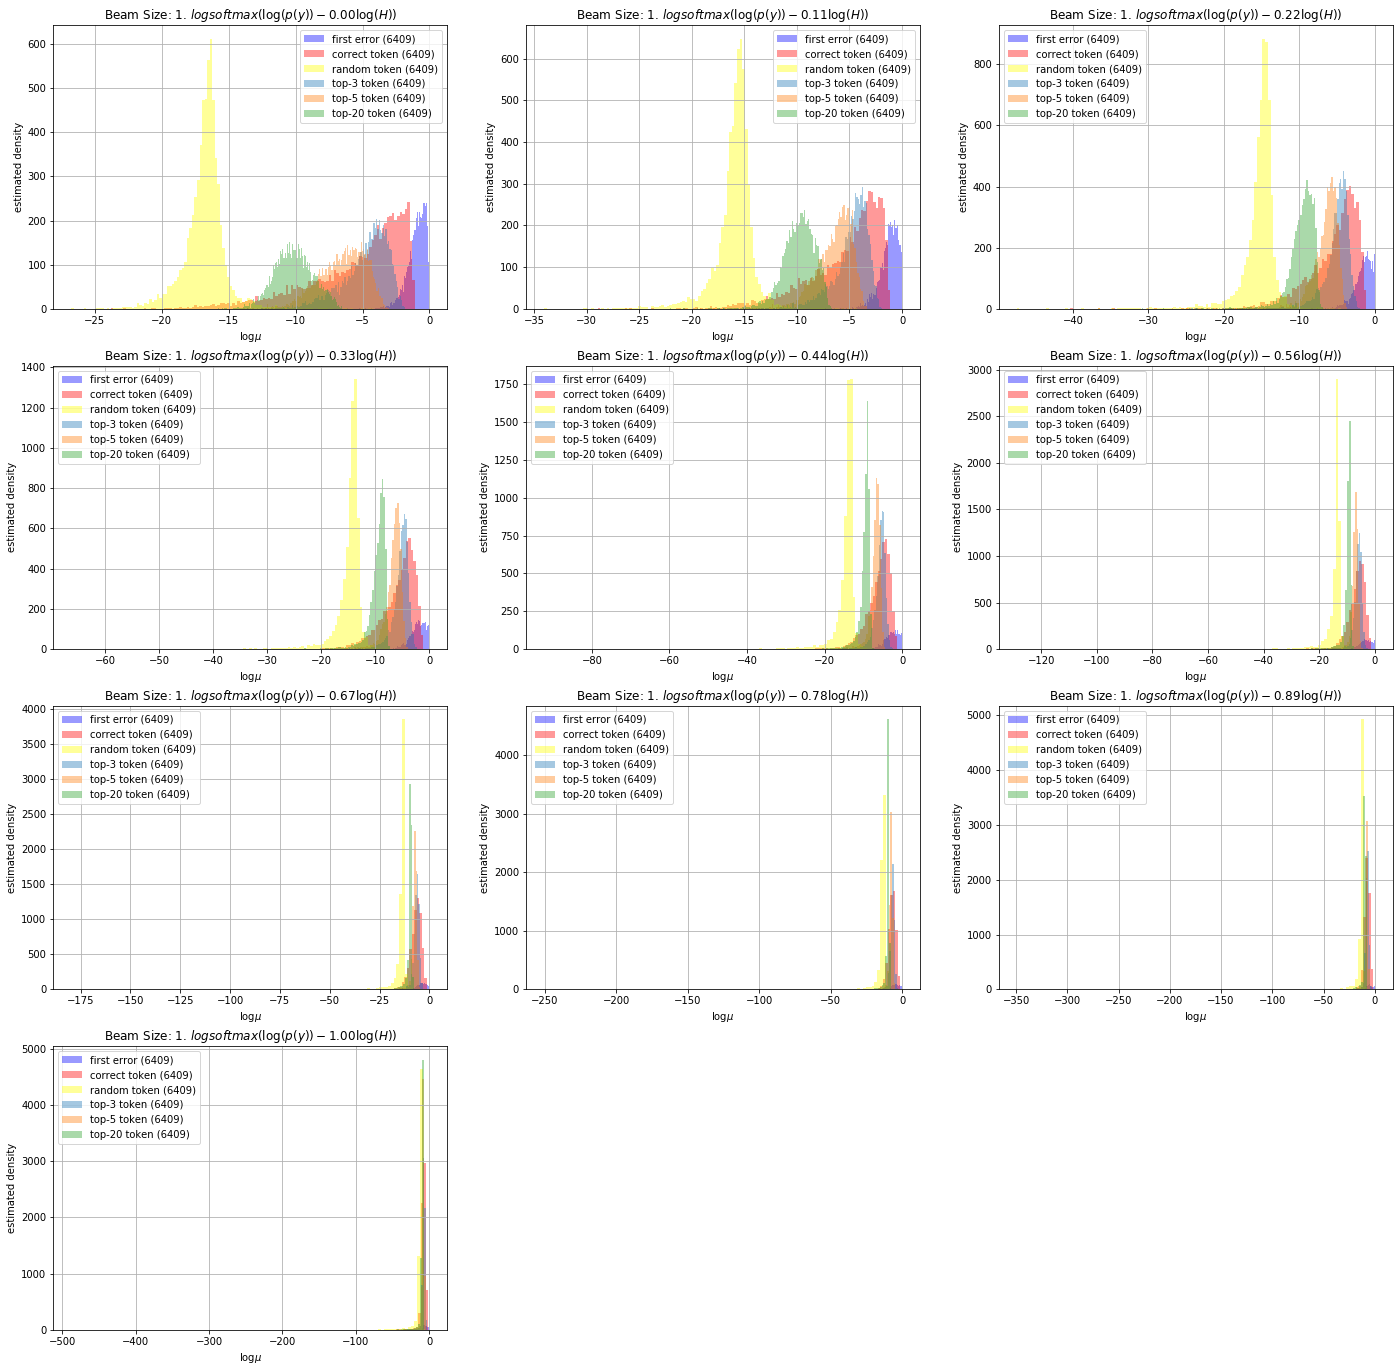

In [133]:
YLIM = (0, 1)
XLIM = (0, 1)

NORMALIZED = False
density = stacked = NORMALIZED
if not NORMALIZED:
    XLIM, YLIM = None, None

XLABEL = r'$\log\mu$'
YLABEL = 'estimated density'

alphas = np.linspace(0, 1, 10)

m = 3
n = alphas.shape[0] // m + (1 if (alphas.shape[0] % m) != 0 else 0)

plt.figure(figsize=(8 * m, 6 * n))
for i, alpha in enumerate(alphas):
    ax = plt.subplot(n, m, i + 1)
    softmax_transformer = lambda ens_logprobs, entropy: softmax(ens_logprobs / (entropy[np.newaxis].T ** alpha), axis=-1)
    get_stats = lambda softmax, tokens: softmax[rows, tokens]

    softmaxes_transformed = softmax_transformer(softmaxes, ens_entropy)

    probs_collection = []
    for tokens in TOP_TOKENS_COLLECTION:
        probs_collection.append(
            get_stats(softmaxes_transformed, tokens)
        )
    # ---------------------------------------------------

    TITLE = r'$logsoftmax(\log(p(y)) - {:.2f}\log(H))$'.format(alpha)

    plot_stat_ax(
        probs_collection,
        TOP_TOKENS_NAMES,
        TOP_TOKENS_COLORS,
        TITLE,
        XLABEL,
        YLABEL,
        XLIM,
        YLIM,
        ax,
        NORMALIZED,
        map_func=safety_log,
        bins=120,
    )